In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import argparse
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from haiku._src.nets.resnet import ResNet18
from jax.lib import xla_bridge
from jax_lensing.model import make_full_field_model
from numpyro import distributions as dist
from numpyro.handlers import condition, seed, trace
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from sbi_lens.normflow.train_model import TrainModel
from tqdm import tqdm
from pathlib import Path
import numpy as np
import jax.numpy.fft as fft
import numpyro
import numpyro.distributions as dist
from tqdm import tqdm


print(xla_bridge.get_backend().platform)

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
    
import psutil
# Get CPU memory usage
cpu_memory_usage = psutil.virtual_memory().percent
print("CPU Memory Usage:", cpu_memory_usage, "%")

import GPUtil
# Get available GPUs
gpus = GPUtil.getGPUs()
for gpu in gpus:
    memory_usage_percentage = (gpu.memoryUsed / gpu.memoryTotal) * 100
    print(f"GPU ID: {gpu.id}, GPU Name: {gpu.name}, GPU Memory Usage: {memory_usage_percentage:.2f}%")

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu
CPU Memory Usage: 17.0 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 0.95%


### LPT Model

In [2]:
def filter(ngrid, reso_rad, cut_off):
    """For now, assume square grid"""
    """
    nsub = int(ngrid/2 + 1)
    i,j  = jnp.meshgrid(np.arange(nsub), np.arange(nsub))
    submatrix = 2*jnp.pi*jnp.sqrt(i**2 + j**2)/reso_rad/jnp.float32(ngrid)

    result = jnp.zeros([ngrid, ngrid])
    result[0:nsub, 0:nsub] = submatrix
    result[0:nsub,nsub:]   = jnp.fliplr(submatrix[:,1:-1])
    result[nsub:,:]        = jnp.flipud(result[1:nsub-1,:])
    tmp = jnp.around(result).astype(int)
    print(np.max(tmp))
    mask=np.ones_like(tmp)
    mask[tmp>cut_off]=0
    """
    nsub = int(ngrid / 2 + 1)
    i, j = jnp.meshgrid(jnp.arange(nsub), jnp.arange(nsub))
    submatrix = 2 * jnp.pi * jnp.sqrt(i**2 + j**2) / reso_rad / jnp.float32(ngrid)

    result = jnp.zeros([ngrid, ngrid])
    result = result.at[0:nsub, 0:nsub].set(submatrix)
    result = result.at[0:nsub, nsub:].set(jnp.fliplr(submatrix[:, 1:-1]))
    result = result.at[nsub:, :].set(jnp.flipud(result[1 : nsub - 1, :]))
    tmp = jnp.around(result).astype(int)

    mask = jnp.ones_like(tmp)
    mask = mask.at[tmp > cut_off].set(0)
    return mask
    

In [3]:
print("######## LPT MODEL ########")
# setting
method = "lpt"

sigma_e = 0.26
ngal = jnp.array([1.7, 1.7, 1.7, 1.7, 1.7])

tmp = jnp.load("/gpfsdswork/projects/rech/eqw/ufa23yn/LPTLensingComparison/jax_lensing/nzs_lsst.npy")

zz = tmp[:, 0]
nz1 = tmp[:, 1]
nz2 = tmp[:, 2]
nz3 = tmp[:, 3]
nz4 = tmp[:, 4]
nz5 = tmp[:, 5]


nz = [nz1, nz2, nz3, nz4, nz5]

nz_shear = [
    jc.redshift.kde_nz(zz, nz[i], bw=0.01, zmax=2.5, gals_per_arcmin2=ngal[i])
    for i in range(5)
]

nbins = len(nz_shear)

# High resolution settings
# Note: this low resolution on the los impacts a tiny bit the cross-correlation signal,
# but it's probably worth it in terms of speed gains
# box_size  = [600., 600., 3500.]     # In Mpc/h [RUN2]
box_size = [400.0, 400.0, 4600.0]  # In Mpc/h [RUN3]
box_shape = [200, 200, 128]  # Number of voxels/particles per side


# Specify the size and resolution of the patch to simulate
field_size = 5.0  # transverse size in degrees [RUN3]
field_npix = 50  # number of pixels per side
pixel_size = field_size * 60 / field_npix
print("Pixel size in arcmin: ", pixel_size)


lowpass = 500
reso = (field_size / field_npix) * 60  # resolution in arcmin.
ang = 0.0166667 * (reso) * 50  # angle of the fullfield in deg

# Noise covariance
print("Computing filter")
f = filter(field_npix, ang / field_npix * 0.0174533, lowpass)


print("Computing noise covriance matrix")
ret = np.zeros((int(field_npix * field_npix), 50000))

for i in range(0, 50000):
    tmp = np.random.normal(
        np.zeros((50, 50)), sigma_e / np.sqrt(ngal[0] * (ang * 60 / field_npix) ** 2)
    )
    ret[:, i] = fft.ifft2(fft.fft2(tmp) * f).real.flatten()

noisecov = np.cov(ret)
print("Done")

# Generate the forward model given these survey settings
lensing_model = jax.jit(
    make_full_field_model(
        field_size=field_size,
        field_npix=field_npix,
        box_size=box_size,
        box_shape=box_shape,
        method=method,
        density_plane_width=100,
        density_plane_npix=300,
    )
)

######## LPT MODEL ########
Pixel size in arcmin:  6.0
Computing filter
Computing noise covriance matrix
Done


In [4]:
# Define the probabilistic model
def model():
    """
    This function defines the top-level forward model for our observations
    """
    # Sampling initial conditions
    initial_conditions = numpyro.sample(
        "initial_conditions", dist.Normal(jnp.zeros(box_shape), jnp.ones(box_shape))
    )

    Omega_b = 0.0492
    Omega_c = numpyro.sample("omega_c", dist.Uniform(0.05, 1.0))
    sigma8 = numpyro.sample("sigma8", dist.Uniform(0.1, 2.0))
    h = numpyro.sample("h_0", dist.Normal(0.6727, 0.063))
    w0 = -1
    n_s = 0.9645

    cosmo = jc.Cosmology(
        Omega_c=Omega_c,
        sigma8=sigma8,
        Omega_b=Omega_b,
        Omega_k=0.0,
        h=h,
        n_s=n_s,
        w0=w0,
        wa=0.0,
    )

    # Generate random convergence maps
    convergence_maps, _ = lensing_model(cosmo, nz_shear, initial_conditions)
    # print(np.array(convergence_maps).shape)

    reso_rad = ang / field_npix * 0.0174533
    nsub = int(field_npix / 2 + 1)
    i, j = jnp.meshgrid(jnp.arange(nsub), jnp.arange(nsub))
    submatrix = (
        2 * jnp.pi * jnp.sqrt(i**2 + j**2) / reso_rad / jnp.float32(field_npix)
    )

    result = jnp.zeros([field_npix, field_npix])
    result = result.at[0:nsub, 0:nsub].set(submatrix)
    result = result.at[0:nsub, nsub:].set(jnp.fliplr(submatrix[:, 1:-1]))
    result = result.at[nsub:, :].set(jnp.flipud(result[1 : nsub - 1, :]))
    tmp = jnp.around(result).astype(int)

    mask = jnp.ones_like(tmp)
    mask = jnp.where(tmp > lowpass, 0, mask)

    obslp = [
        fft.ifft2(fft.fft2(convergence_maps[i]) * mask).real
        for i in range(len(convergence_maps))
    ]

    observed_maps = [
        numpyro.sample(
            "kappa_%d" % i,
            dist.MultivariateNormal(
                obslp[i].flatten(),
                noisecov + 1e-10 * jnp.eye(int(field_npix * field_npix)),
            ),
        )
        for i in range(len(convergence_maps))
    ]

    return observed_maps

In [5]:
@jax.jit
@jax.vmap
def augmentation_noise(x, key):
    keys = jax.random.split(key, len(x))
    observed_maps = [
        dist.MultivariateNormal(
                x[i],
                noisecov + 1e-10 * jnp.eye(int(field_npix * field_npix)),
            ).sample(keys[i])
        for i in range(len(x))
        ]
    noisy_map = jnp.stack(observed_maps, axis=-1)
    noisy_map = noisy_map.reshape([field_npix,field_npix,nbins])

    return noisy_map

### Fiducial Model

In [6]:
# print("######### FIDUCIAL MODEL ##########")
# # condition the model on a given set of parameters

gen_model = condition(
    model, 
    {"omega_c": 0.2664,
      "sigma8": 0.831,
      "h_0": 0.6727
     }
)
model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(gen_model, jax.random.PRNGKey(1234) ))
model_trace  = model_tracer.get_trace()

m_data = jnp.stack([model_trace["kappa_%d" % i]["value"] for i in range(5)], axis=-1).reshape([field_npix, field_npix, nbins])

truth = [0.2664, 0.831, 0.6727]

/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

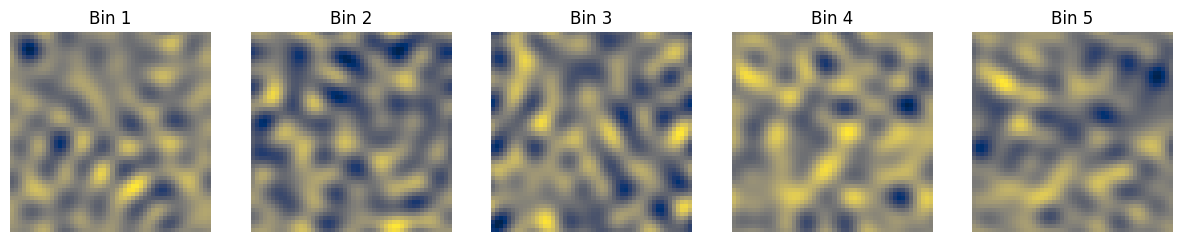

In [7]:
plt.figure(figsize=(15,5))

for i in range(5):
  plt.subplot(1,5, i+1)
  plt.imshow(m_data[...,i], cmap='cividis'); #plt.colorbar();
  plt.title('Bin %d'%(i+1))
  plt.axis('off')

In [11]:
# m_data_without_noise = [model_trace["kappa_%d" % i]["fn"].mean for i in range(5)]
# tetst=augmentation_noise(m_data_without_noise, jax.random.PRNGKey(1234))

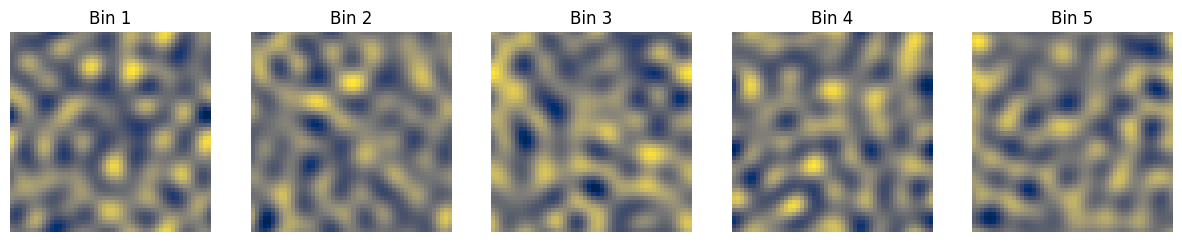

In [12]:
# plt.figure(figsize=(15,5))

# for i in range(5):
#   plt.subplot(1,5, i+1)
#   plt.imshow(tetst[...,i] - np.array([model_trace["kappa_%d" % i]["fn"].mean]).reshape([50,50]), cmap='cividis');#plt.colorbar();
#   plt.title('Bin %d'%(i+1))
#   plt.axis('off')

### Generating data

In [9]:
print("######## DATA GENERATION ########")

@jax.jit
@jax.vmap
def get_data(key):
    seeded_model = numpyro.handlers.seed(model, key)
    model_trace = numpyro.handlers.trace(seeded_model).get_trace()
    kmap_obs =  jnp.stack([model_trace['kappa_0']['value'],
                        model_trace['kappa_1']['value'],
                        model_trace['kappa_2']['value'],
                        model_trace['kappa_3']['value'],
                        model_trace['kappa_4']['value']], axis=-1)
    kmap_obs = kmap_obs.reshape([field_npix, field_npix, nbins])
    
    kmap = jnp.stack([model_trace['kappa_0']['fn'].mean,
                        model_trace['kappa_1']['fn'].mean,
                        model_trace['kappa_2']['fn'].mean,
                        model_trace['kappa_3']['fn'].mean,
                        model_trace['kappa_4']['fn'].mean], axis=0)
    theta = jnp.stack(
        [
            model_trace["omega_c"]["value"],
            model_trace["sigma8"]["value"],
            model_trace["h_0"]["value"],
        ]
    )

    return theta, kmap_obs, kmap

# training dataset
params_train = []
maps_train = []
maps_train_obs = []
masterkey = jax.random.PRNGKey(42)
bs = 15

for i in tqdm(range(10_000)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap_obs, kmap = get_data(jax.random.split(key, bs))
    params_train.append(params)
    maps_train.append(kmap)
    maps_train_obs.append(kmap_obs)

params_train = np.stack(params_train).reshape([-1, 3])
maps_train_obs = np.stack(maps_train_obs).reshape([-1, field_npix, field_npix, nbins])
maps_train = np.stack(maps_train).reshape([-1, nbins, field_npix*field_npix])
dataset_train = {"theta": params_train, "maps_obs": maps_train_obs, "maps": maps_train}

del maps_train, maps_train_obs, params_train

# test dataset
params_test = []
maps_test = []
maps_test_obs = []
masterkey = jax.random.PRNGKey(20)
bs = 15

for i in tqdm(range(500)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap_obs, kmap = get_data(jax.random.split(key, bs))
    params_test.append(params)
    maps_test.append(kmap)
    maps_test_obs.append(kmap_obs)

params_test = np.stack(params_test).reshape([-1, 3])
maps_test_obs = np.stack(maps_test_obs).reshape([-1, field_npix, field_npix, nbins])
maps_test = np.stack(maps_test).reshape([-1, nbins, field_npix*field_npix])
dataset_test = {"theta": params_test, "maps_obs": maps_test_obs, "maps": maps_test}

del maps_test, maps_test_obs, params_test

######## DATA GENERATION ########


100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


In [12]:
from pickle import dump, load, HIGHEST_PROTOCOL

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file, protocol=HIGHEST_PROTOCOL)

# Save the train dataset
pickle_dump(dataset_train, f"train_dataset_{method}.pkl")

# Save the test dataset
pickle_dump(dataset_test, f"test_dataset_{method}.pkl")

In [8]:
from pickle import dump, load, HIGHEST_PROTOCOL

def pickle_load(path):
    with open(path, 'rb') as file:
        return load(file) 

dataset_train = pickle_load(f"train_dataset_{method}.pkl")

dataset_test = pickle_load(f"test_dataset_{method}.pkl")

### Check augmentation noise 

In [62]:
# Compute the power spectra and cross correlations of all maps
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
float64 = np.float64

N_sample = 100
n_nz_bins = 6

gen_model = condition(
    model, 
    {"omega_c": 0.2664,
      "sigma8": 0.831,
      "h_0": 0.6727
     }
)
model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(gen_model, jax.random.PRNGKey(1234) ))
model_trace  = model_tracer.get_trace()

Cl_list = []
for i in range(N_sample):
    model_trace = model_tracer.get_trace()
    m_data = jnp.stack([model_trace['kappa_0']['value'],
                        model_trace['kappa_1']['value'],
                        model_trace['kappa_2']['value'],
                        model_trace['kappa_3']['value'],
                        model_trace['kappa_4']['value']], axis=0)
    m_data = m_data.reshape([5,50,50])
    Cl_list.append(m_data)

l_edges_kmap= np.linspace(100, 5000, 128)
lis=[0,1,2,3,4]
p_cross_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    # m_data=jnp.transpose(m_data, [2, 0, 1])
    p_cross=[]
    for i, j in itertools.combinations(lis, 2):
        pi=ConvergenceMap(m_data[i], angle=field_size*u.deg).cross(ConvergenceMap(m_data[j], angle=field_size*u.deg),l_edges=l_edges_kmap)[1]
        p_cross.append(pi)
    p_cross_sample.append(p_cross)
ell_sample=ConvergenceMap(m_data[0], angle=field_size*u.deg).cross(ConvergenceMap(m_data[0], angle=field_size*u.deg),l_edges=l_edges_kmap)[0]


p_auto_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    # m_data=jnp.transpose(m_data, [2, 0, 1])
    p_auto=[]
    for i in range(n_nz_bins):
        pi=ConvergenceMap(m_data[i], angle=field_size*u.deg).powerSpectrum(l_edges_kmap)[1]
        p_auto.append(pi)
    p_auto_sample.append(p_auto)

#some useful functions to make the plot
def fill_lower_and_diag(array,nl):
    n = int(np.sqrt(len(array)*2))
    mask = np.arange(n)[:,None] >= np.arange(n)
    out = np.zeros((n,n,nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T


def fill_lower_diag(array,nl):
    n = int(np.sqrt(len(array)*2))+1
    mask = np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n, nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T

n_z_bins=len(nz_shear)

Cl_cross_arr = np.array(p_cross_sample)
Cl_mean_cross  = np.mean(Cl_cross_arr, axis=0)
Cl_lower_cross = np.percentile(Cl_cross_arr, 2.5, axis=0)
Cl_upper_cross = np.percentile(Cl_cross_arr, 97.5, axis=0)

Cl_auto_arr = np.array(p_auto_sample)
Cl_mean_auto  = np.mean(Cl_auto_arr, axis=0)
Cl_lower_auto = np.percentile(Cl_auto_arr, 2.5, axis=0)
Cl_upper_auto = np.percentile(Cl_auto_arr, 97.5, axis=0)

Cl_mean_sample_cross=fill_lower_diag(Cl_mean_cross,127)
Cl_lower_sample_cross=fill_lower_diag(Cl_lower_cross,127)
Cl_upper_sample_cross=fill_lower_diag(Cl_upper_cross,127)


ell_sample2 = ell_sample
Cl_mean_auto2 = Cl_mean_auto
Cl_lower_auto2 = Cl_lower_auto
Cl_upper_auto2 = Cl_upper_auto
Cl_mean_sample_cross2 = Cl_mean_sample_cross
Cl_lower_sample_cross2 = Cl_lower_sample_cross
Cl_upper_sample_cross2 = Cl_upper_sample_cross

In [100]:
# Compute the power spectra and cross correlations of all maps
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
float64 = np.float64

N_sample = 100
n_nz_bins = 6

Cl_list = []
masterkey = jax.random.PRNGKey(0)
for i in range(N_sample):
    key, masterkey = jax.random.split(masterkey)
    model_trace = model_tracer.get_trace()
    m_data = [
        model_trace['kappa_0']['fn'].mean,
        model_trace['kappa_1']['fn'].mean,
        model_trace['kappa_2']['fn'].mean,
        model_trace['kappa_3']['fn'].mean,
        model_trace['kappa_4']['fn'].mean
    ]
    m_data = jnp.stack(m_data, axis = 0)
    m_data = augmentation_noise(m_data,key)
    Cl_list.append(m_data)
    

l_edges_kmap= np.linspace(100, 5000, 128)
lis=[0,1,2,3,4]
p_cross_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    m_data=jnp.transpose(m_data, [2, 0, 1])
    p_cross=[]
    for i, j in itertools.combinations(lis, 2):
        pi=ConvergenceMap(m_data[i], angle=field_size*u.deg).cross(ConvergenceMap(m_data[j], angle=field_size*u.deg),l_edges=l_edges_kmap)[1]
        p_cross.append(pi)
    p_cross_sample.append(p_cross)
ell_sample=ConvergenceMap(m_data[0], angle=field_size*u.deg).cross(ConvergenceMap(m_data[0], angle=field_size*u.deg),l_edges=l_edges_kmap)[0]


p_auto_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    m_data=jnp.transpose(m_data, [2, 0, 1])
    p_auto=[]
    for i in range(n_nz_bins):
        pi=ConvergenceMap(m_data[i], angle=field_size*u.deg).powerSpectrum(l_edges_kmap)[1]
        p_auto.append(pi)
    p_auto_sample.append(p_auto)

#some useful functions to make the plot
def fill_lower_and_diag(array,nl):
    n = int(np.sqrt(len(array)*2))
    mask = np.arange(n)[:,None] >= np.arange(n)
    out = np.zeros((n,n,nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T


def fill_lower_diag(array,nl):
    n = int(np.sqrt(len(array)*2))+1
    mask = np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n, nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T

n_z_bins=len(nz_shear)

Cl_cross_arr = np.array(p_cross_sample)
Cl_mean_cross  = np.mean(Cl_cross_arr, axis=0)
Cl_lower_cross = np.percentile(Cl_cross_arr, 2.5, axis=0)
Cl_upper_cross = np.percentile(Cl_cross_arr, 97.5, axis=0)

Cl_auto_arr = np.array(p_auto_sample)
Cl_mean_auto  = np.mean(Cl_auto_arr, axis=0)
Cl_lower_auto = np.percentile(Cl_auto_arr, 2.5, axis=0)
Cl_upper_auto = np.percentile(Cl_auto_arr, 97.5, axis=0)

Cl_mean_sample_cross=fill_lower_diag(Cl_mean_cross,127)
Cl_lower_sample_cross=fill_lower_diag(Cl_lower_cross,127)
Cl_upper_sample_cross=fill_lower_diag(Cl_upper_cross,127)

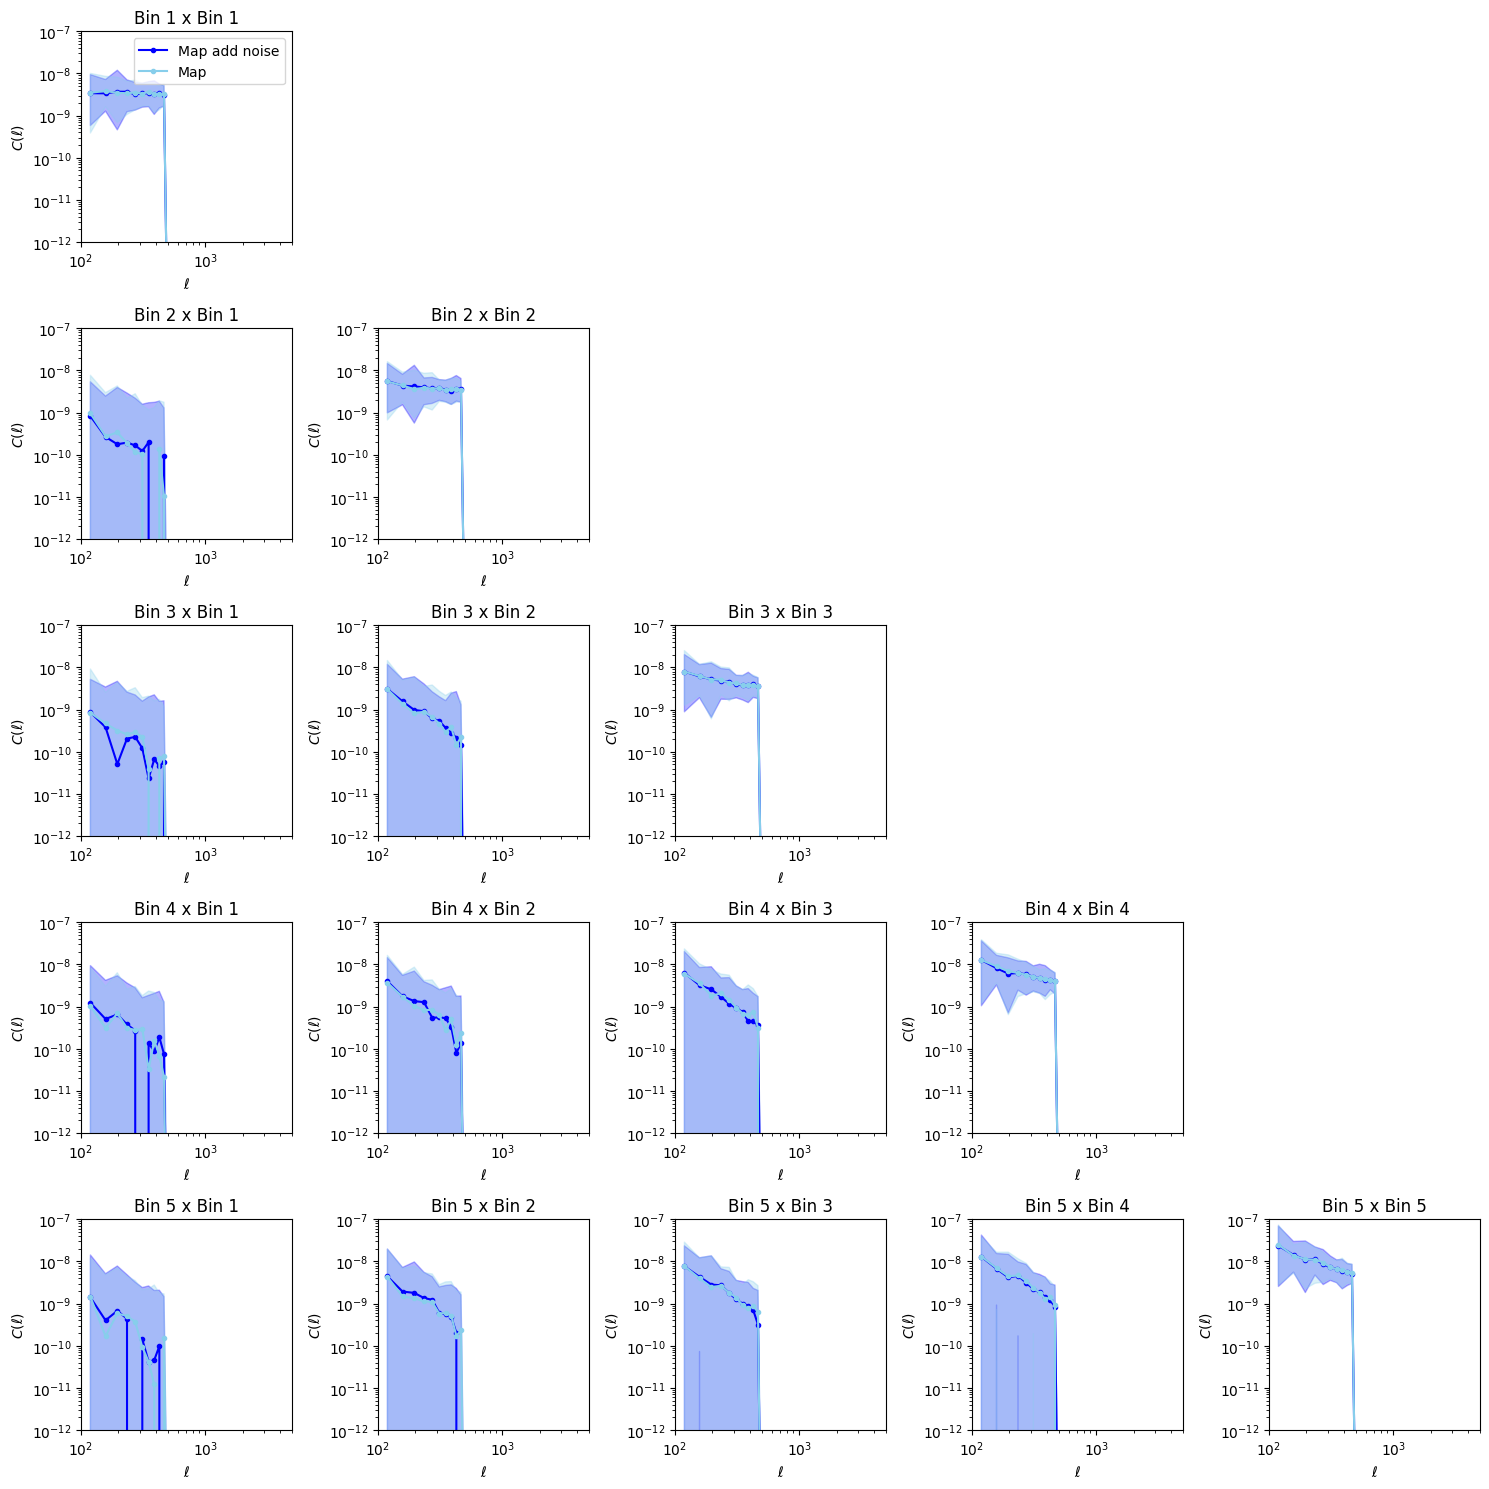

In [101]:
fig, ax = plt.subplots(n_z_bins, n_z_bins, figsize=(15,15))
col = ['blue', 'skyblue', 'black', 'red']

for i in range(n_z_bins):
    for j in range(n_z_bins):
        if(j>i):
            ax[i,j].axis('off')
        else:
            ax[i,j].set_title('Bin %d x Bin %d'%(i+1,j+1))
            ax[i,j].set_xlabel('$\ell$')
            ax[i,j].set_ylabel('$C(\ell)$')
            ax[i,j].set_xlim(100., 5000.)
            ax[i,j].set_ylim(1e-12, 1e-7)
            # ax[i,j].axvline(1000, ls='--')
            if i==j:
                ax[i,j].loglog(ell_sample, Cl_mean_auto[i], '.-', color=col[0], label='Map add noise')
                ax[i,j].fill_between(ell_sample, Cl_lower_auto[i], Cl_upper_auto[i], color=col[0], alpha=0.3)

                ax[i,j].loglog(ell_sample2, Cl_mean_auto2[i], '.-', color=col[1], label='Map')
                ax[i,j].fill_between(ell_sample2, Cl_lower_auto2[i], Cl_upper_auto2[i], color=col[1], alpha=0.3)
            else:
                ax[i,j].loglog(ell_sample, Cl_mean_sample_cross[:,i,j], '.-', color=col[0], label='Map add noise')
                ax[i,j].fill_between(ell_sample, Cl_lower_sample_cross[:, i,j], Cl_upper_sample_cross[:,i,j], color=col[0], alpha=0.3)
                
                ax[i,j].loglog(ell_sample2, Cl_mean_sample_cross2[:,i,j], '.-', color=col[1], label='Map')
                ax[i,j].fill_between(ell_sample2, Cl_lower_sample_cross2[:, i,j], Cl_upper_sample_cross2[:,i,j], color=col[1], alpha=0.3)

ax[0,0].legend()
plt.tight_layout()
plt.show()

### Compressing Data

In [9]:
dim = 3

In [10]:
print("######## CREATE COMPRESSOR ########")
# nf
bijector_layers_compressor = [128] * 6

bijector_compressor = partial(
    AffineCoupling, layers=bijector_layers_compressor, activation=jax.nn.silu
)

NF_compressor = partial(ConditionalRealNVP, n_layers=4, bijector_fn=bijector_compressor)


class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(dim)(y)
        return nvp


nf = hk.without_apply_rng(
    hk.transform(lambda theta, y: Flow_nd_Compressor()(y).log_prob(theta).squeeze())
)

# compressor
class CompressorCNN2D(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim

    def __call__(self, x):
        net_x = hk.Conv2D(32, 3, 2)(x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(64, 3, 2)(net_x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(128, 3, 2)(net_x)
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.AvgPool(16,8,'SAME')(net_x) 
        net_x = hk.Flatten()(net_x)

        net_x = hk.Linear(self.output_dim)(net_x)
        
        return net_x.squeeze()
    
compressor = hk.transform_with_state(lambda y: CompressorCNN2D(dim)(y))
compressor_eval = hk.transform_with_state(lambda y: CompressorCNN2D(dim)(y))

######## CREATE COMPRESSOR ########


In [11]:
print("######## TRAIN ########")

# init compressor
parameters_resnet, opt_state_resnet = compressor.init(
    jax.random.PRNGKey(0), y=0.5 * jnp.ones([1, field_npix, field_npix, nbins])
)
# init nf
params_nf = nf.init(
    jax.random.PRNGKey(0), theta=0.5 * jnp.ones([1, dim]), y=0.5 * jnp.ones([1, dim])
)

parameters_compressor = hk.data_structures.merge(parameters_resnet, params_nf)

del parameters_resnet, params_nf

# define optimizer
total_steps = 10_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={
        int(total_steps * 0.1): 0.7,
        int(total_steps * 0.2): 0.7,
        int(total_steps * 0.3): 0.7,
        int(total_steps * 0.4): 0.7,
        int(total_steps * 0.5): 0.7,
        int(total_steps * 0.6): 0.7,
        int(total_steps * 0.7): 0.7,
        int(total_steps * 0.8): 0.7,
        int(total_steps * 0.9): 0.7,
    },
)

optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)

model_compressor = TrainModel(
    compressor=compressor,
    nf=nf,
    optimizer=optimizer_c,
    loss_name="train_compressor_vmim",
)

update = jax.jit(model_compressor.update)

batch_size = 128
masterkey =jax.random.PRNGKey(0)
store_loss = []
loss_train = []
loss_test = []
for batch in tqdm(range(total_steps)):
    key,key2,masterkey = jax.random.split(masterkey,3)
    inds = np.random.randint(0, len(dataset_train["theta"]), batch_size)
    if not jnp.isnan(dataset_train["theta"][inds]).any():
        data_map = augmentation_noise(dataset_train["maps"][inds], jax.random.split(key2, batch_size))
        # data_map = dataset_train["maps_obs"][inds2]
        # data_map = jnp.transpose(data_map, [0,2,3,1])
        b_loss, parameters_compressor, opt_state_c, opt_state_resnet = update(
            model_params=parameters_compressor,
            opt_state=opt_state_c,
            theta=dataset_train["theta"][inds],
            x=data_map, 
            state_resnet=opt_state_resnet,
        )

        store_loss.append(b_loss)

        if jnp.isnan(b_loss):
            print("NaN Loss")
            break
            
    if batch % 100 == 0:

        # # Get CPU memory usage
        # cpu_memory_usage = psutil.virtual_memory().percent
        # print("CPU Memory Usage:", cpu_memory_usage, "%")
        # # Get available GPUs
        # gpus = GPUtil.getGPUs()
        # for gpu in gpus:
        #     memory_usage_percentage = (gpu.memoryUsed / gpu.memoryTotal) * 100
        #     print(f"GPU ID: {gpu.id}, GPU Name: {gpu.name}, GPU Memory Usage: {memory_usage_percentage:.2f}%")

        # save params
        with open(f"./save_params/{method}/params_nd_compressor_batch{batch}.pkl", "wb") as fp:
            pickle.dump(parameters_compressor, fp)

        with open(f"./save_params/{method}/opt_state_resnet_batch{batch}.pkl", "wb") as fp:
            pickle.dump(opt_state_resnet, fp)


        inds2 = np.random.randint(0, len(dataset_test["theta"]), batch_size)
        key,masterkey = jax.random.split(masterkey)
        data_map_test = dataset_test["maps_obs"][inds2]
        # data_map_test = jnp.transpose(data_map_test, [0,2,3,1])
        b_loss_test, _, _, _ = update(
            model_params=parameters_compressor,
            opt_state=opt_state_c,
            theta=dataset_test["theta"][inds2],
            x=data_map_test, 
            state_resnet=opt_state_resnet,
        )

        loss_train.append(b_loss)
        loss_test.append(b_loss_test)

        jnp.save(f"./save_params/{method}/loss_train.npy", loss_train)
        jnp.save(f"./save_params/{method}/loss_test.npy", loss_test)


with open(f"./save_params/{method}/params_nd_compressor_batch{batch}.pkl", "wb") as fp:
    pickle.dump(parameters_compressor, fp)

with open(f"./save_params/{method}/opt_state_resnet_batch{batch}.pkl", "wb") as fp:
    pickle.dump(opt_state_resnet, fp)

######## TRAIN ########


100%|██████████| 10000/10000 [02:40<00:00, 62.23it/s]


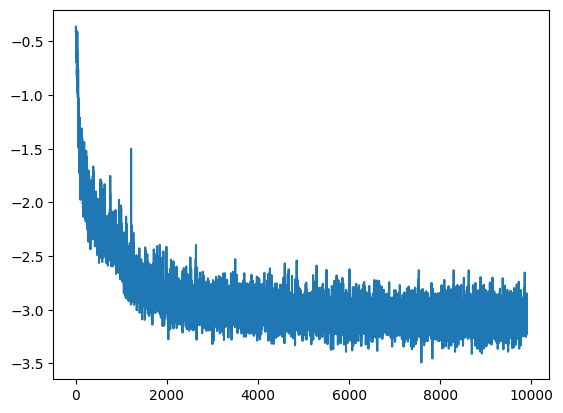

In [12]:
plt.plot(store_loss[100:])

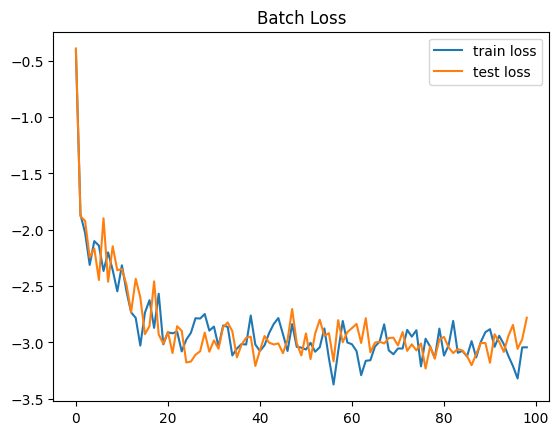

In [13]:
plt.figure()
plt.plot(loss_train[1:], label="train loss")
plt.plot(loss_test[1:], label="test loss")
plt.legend()
plt.title("Batch Loss")
plt.savefig(f"./fig/{method}/loss_compressor_train_test")

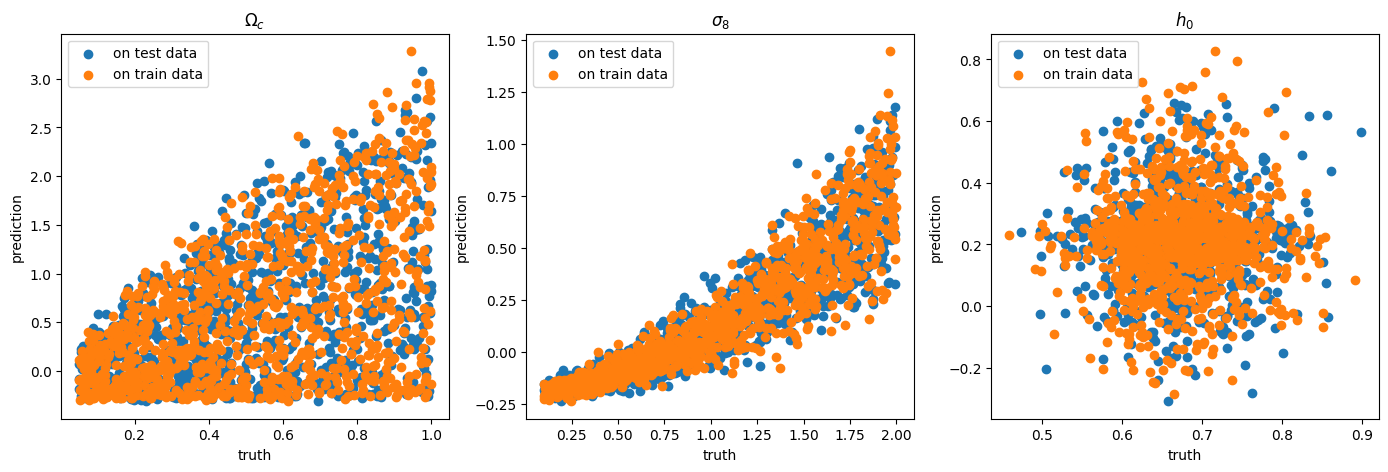

In [14]:
compressed_dataset_train, _ = compressor_eval.apply(
    parameters_compressor,
    opt_state_resnet,
    None,
    augmentation_noise(dataset_train["maps"][:1000], jax.random.split(key2, 1000)), # dataset_train['maps_obs'][:1000].reshape([-1, field_npix, field_npix, nbins]),
)

compressed_dataset_test, _ = compressor_eval.apply(
    parameters_compressor,
    opt_state_resnet,
    None,
    dataset_test['maps_obs'][:1000].reshape([-1, field_npix, field_npix, nbins]),
)

params_name = [r'$\Omega_c$',r'$\sigma_8$',r'$h_0$']
plt.figure(figsize=(35,5))
for i in range(3):
    plt.subplot(1,6,i+1)\
    
    plt.scatter(dataset_test['theta'][:1000,i], compressed_dataset_test[:,i], label = 'on test data')
    plt.scatter(dataset_train['theta'][:1000,i], compressed_dataset_train[:,i], label = 'on train data')
    plt.xlabel('truth')
    plt.ylabel('prediction')
    plt.title(params_name[i])
    plt.legend()

<Figure size 640x480 with 0 Axes>

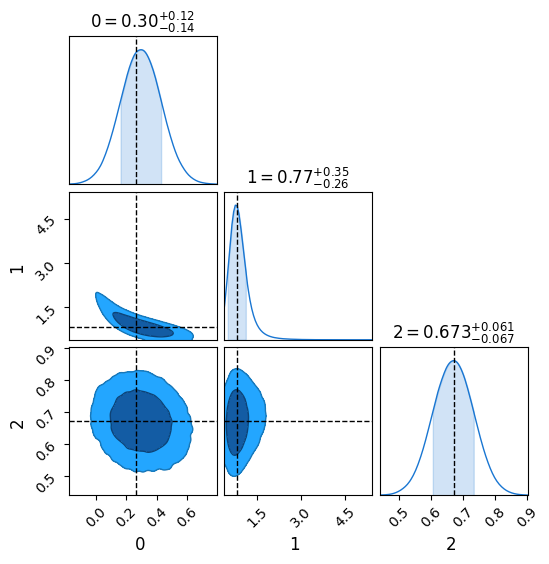

In [15]:
# m_data = jnp.transpose(m_data, [1,2,0])
y, _ = compressor_eval.apply(
    parameters_compressor,
    opt_state_resnet,
    None,
    m_data.reshape([1, field_npix, field_npix, nbins]),
)

nvp_sample_nd = hk.transform(
    lambda x: Flow_nd_Compressor()(x).sample(100000, seed=hk.next_rng_key())
)
sample_nd = nvp_sample_nd.apply(
    parameters_compressor,
    rng=jax.random.PRNGKey(43),
    x=y * jnp.ones([100000, dim]),
)
idx = jnp.where(jnp.isnan(sample_nd))[0]
sample_nd = jnp.delete(sample_nd, idx, axis=0)

plt.figure()
c = ChainConsumer()
c.add_chain(sample_nd, name="SBI")
fig = c.plotter.plot(figsize=1.2, truth=truth)

plt.savefig(f"./fig/{method}/contour_plot_compressor_batch{batch}")

### Inference

In [16]:
print("######## COMPRESS DATA ########")


@jax.jit
@jax.vmap
def get_data(key):
    seeded_model = numpyro.handlers.seed(model, key)
    model_trace = numpyro.handlers.trace(seeded_model).get_trace()
    kmap_obs =  jnp.stack([model_trace['kappa_0']['value'],
                        model_trace['kappa_1']['value'],
                        model_trace['kappa_2']['value'],
                        model_trace['kappa_3']['value'],
                        model_trace['kappa_4']['value']], axis=-1)
    kmap_obs = kmap_obs.reshape([field_npix, field_npix, nbins])
    
    kmap = jnp.stack([model_trace['kappa_0']['fn'].mean,
                        model_trace['kappa_1']['fn'].mean,
                        model_trace['kappa_2']['fn'].mean,
                        model_trace['kappa_3']['fn'].mean,
                        model_trace['kappa_4']['fn'].mean], axis=0)
    theta = jnp.stack(
        [
            model_trace["omega_c"]["value"],
            model_trace["sigma8"]["value"],
            model_trace["h_0"]["value"],
        ]
    )

    return theta, kmap_obs, kmap

# test dataset
params_train = []
maps_train = []
masterkey = jax.random.PRNGKey(2988)
bs = 15

for i in tqdm(range(5000)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap_obs, kmap = get_data(jax.random.split(key, bs))
    params_train.append(params)
    maps_train.append(kmap_obs)

params_train = np.stack(params_train).reshape([-1, 3])
maps_train = np.stack(maps_train).reshape([-1, field_npix, field_npix, nbins])
dataset_train = {"theta": params_train, "maps": maps_train}

data_compressed, _ = compressor_eval.apply(
    parameters_compressor, 
    opt_state_resnet, 
    None, 
    dataset_train['maps'].reshape([-1,field_npix, field_npix, nbins])
)

train_dataset_compressed = {'theta':dataset_train['theta'], 'x':data_compressed}


#######################################################

# test dataset
params_test = []
maps_test = []
masterkey = jax.random.PRNGKey(53542)
bs = 15

for i in tqdm(range(300)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap_obs, kmap = get_data(jax.random.split(key, bs))
    params_test.append(params)
    maps_test.append(kmap_obs)

params_test = np.stack(params_test).reshape([-1, 3])
maps_test = np.stack(maps_test).reshape([-1, field_npix, field_npix, nbins])
dataset_test = {"theta": params_test, "maps": maps_test}


data_compressed, _ = compressor_eval.apply(
    parameters_compressor, 
    opt_state_resnet, 
    None, 
    dataset_test['maps'].reshape([-1,field_npix, field_npix, nbins])
)
test_dataset_compressed = {'theta':dataset_test['theta'], 'x':data_compressed}

######## COMPRESS DATA ########


  0%|          | 0/5000 [00:00<?, ?it/s]/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] -

In [17]:
from pickle import dump, load, HIGHEST_PROTOCOL

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file, protocol=HIGHEST_PROTOCOL)

# Save the train dataset
pickle_dump(train_dataset_compressed, f"compressed_train_dataset_{method}.pkl")

# Save the test dataset
pickle_dump(test_dataset_compressed, f"compressed_test_dataset_{method}.pkl")

In [18]:
print("######## CREATE NDE ########")
# Create neural density estimator (NDE) to approximate p(theta | y)

summary_stat_dim = dim
nb_params_to_infer = dim
batch_size = 128


# Affine bijection used in the RealNVP coupling
bijector_ff = partial(
  AffineCoupling,
  layers=[128] * 2,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_ff = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_ff
)


# log probability of the NDE
nf_logp_ff = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF_ff(nb_params_to_infer)(y).log_prob(theta).squeeze()
    )
)

# sampling of the NDE
nf_sample_ff = hk.transform(
  lambda y : NF_ff(nb_params_to_infer)(y).sample(100_000, seed=hk.next_rng_key())
)

######## CREATE NDE ########


In [19]:
print("######## UTILS FUN ########")

# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nf_logp_ff.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

######## UTILS FUN ########


######## TRAINING ########


loss -3.052: 100%|██████████| 30000/30000 [02:09<00:00, 231.03it/s]


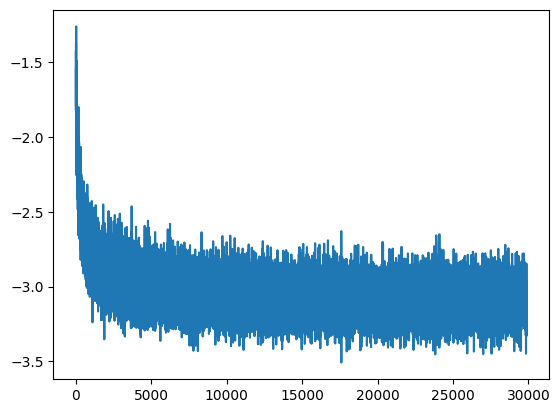

In [20]:
print("######## TRAINING ########")
# init nf params
params_ff = nf_logp_ff.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.zeros([1, summary_stat_dim]),
    0.5 * jnp.zeros([1, nb_params_to_infer])
)

total_steps = 30_000
nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=1e-3,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-6,
)

# define optimizer
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_ff = optimizer.init(params_ff)


# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
loss_train = []
loss_test=[]
pbar = tqdm(range(total_steps))

for batch in pbar:
    inds = np.random.randint(0, len(train_dataset_compressed['theta']), batch_size)

    l, params_ff, opt_state_ff = update(
      params_ff,
      opt_state_ff,
      train_dataset_compressed['theta'][inds],
      train_dataset_compressed['x'][inds],
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    
    
    if batch % 1_000 == 0:

        # save params
        with open(f"./save_params/params_nd_flow_batch{batch}.pkl", "wb") as fp:
            pickle.dump(params_ff, fp)


        inds2 = np.random.randint(0, len(test_dataset_compressed["theta"]), batch_size)
        b_loss_test, _, _ = update(
          params_ff,
          opt_state_ff,
          test_dataset_compressed["theta"][inds2],
          test_dataset_compressed['x'][inds2],
        )
        

        loss_train.append(l)
        loss_test.append(b_loss_test)

        
plt.plot(batch_loss[100:])

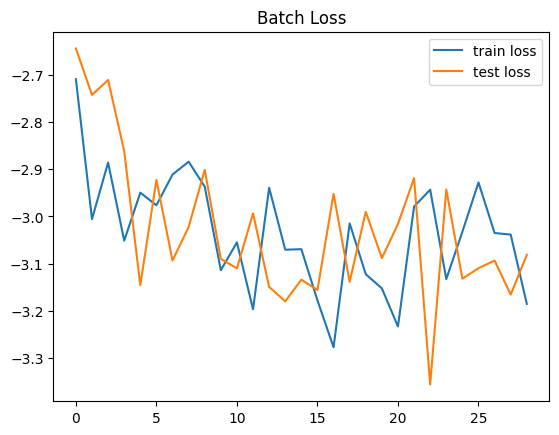

In [21]:
plt.figure()
plt.plot(loss_train[1:], label="train loss")
plt.plot(loss_test[1:], label="test loss")
plt.legend()
plt.title("Batch Loss")
plt.savefig("./fig/loss_compressor_train_test")

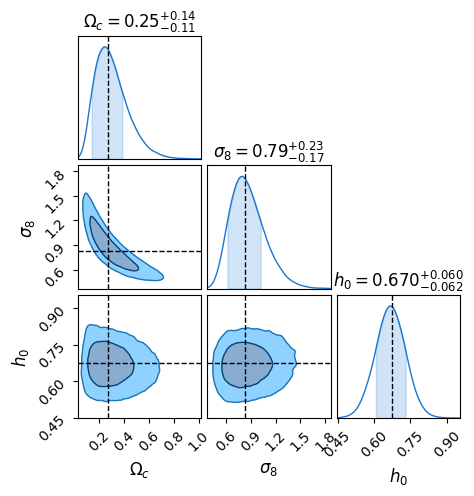

In [22]:
from chainconsumer import ChainConsumer

observed_map_compressed, _ = compressor_eval.apply(
    parameters_compressor,
    opt_state_resnet,
    None,
    m_data.reshape([1,field_npix,field_npix,nbins])
)

posterior_ff = nf_sample_ff.apply(
      params_ff,
      rng = jax.random.PRNGKey(70),
      y = observed_map_compressed * jnp.ones([100_000, summary_stat_dim])
)


c = ChainConsumer()

c.add_chain(
    posterior_ff,
    shade_alpha = 0.5,
    name='Implicit full-field',
    parameters=['$\Omega_c$','$\sigma_8$', '$h_0$'],
)

fig = c.plotter.plot(figsize=1.,truth=truth)

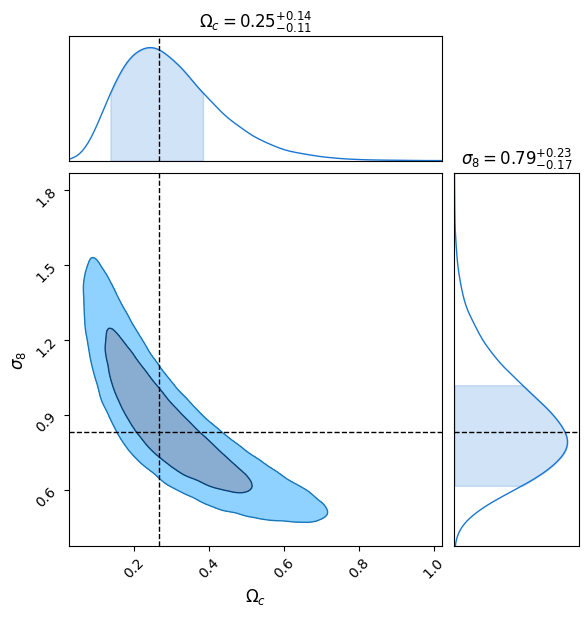

In [23]:
from chainconsumer import ChainConsumer

observed_map_compressed, _ = compressor_eval.apply(
    parameters_compressor,
    opt_state_resnet,
    None,
    m_data.reshape([1,field_npix,field_npix,nbins])
)

posterior_ff = nf_sample_ff.apply(
      params_ff,
      rng = jax.random.PRNGKey(70),
      y = observed_map_compressed * jnp.ones([100_000, summary_stat_dim])
)


c = ChainConsumer()

c.add_chain(
    posterior_ff[:,:2],
    shade_alpha = 0.5,
    name='Implicit full-field',
    parameters=['$\Omega_c$','$\sigma_8$'],
)


fig = c.plotter.plot(figsize=2.,truth=truth[:2])

In [24]:
jnp.save('implicit_inference_lpt.npy', posterior_ff)